<a href="https://colab.research.google.com/github/davidyu8/gouda-group-project/blob/main/recipe_classifier_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Purpose: Classify recipes using the machine learning techniques we practiced in class. Specifically, we will do the classification by cuisine.

Data: https://www.kaggle.com/c/whats-cooking/data

Much of the code of the original draft was taken from Phil's lecture (https://github.com/PhilChodrow/PIC16B/blob/master/lectures/tf/tf-3.ipynb)

Outline:
1. Set up the data into a TensorFlow dataset
2. Build and compile the model
3. Classify!

In [1]:
# imports
import json
import pandas as pd
import numpy as np

import re
import string

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import plotly.express as px 
import plotly.io as pio
pio.templates.default = "plotly_white"

In [3]:
# read in data
from google.colab import files
uploaded = files.upload()

Saving train.json to train.json


In [13]:
df = pd.read_json('train.json')
df

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


In [14]:
df.drop(columns = ["id"])
df.groupby("cuisine").size()

cuisine
brazilian        467
british          804
cajun_creole    1546
chinese         2673
filipino         755
french          2646
greek           1175
indian          3003
irish            667
italian         7838
jamaican         526
japanese        1423
korean           830
mexican         6438
moroccan         821
russian          489
southern_us     4320
spanish          989
thai            1539
vietnamese       825
dtype: int64

In [15]:
# send column from list to str
df["ingredients"] = df["ingredients"].apply(lambda x: ' '.join(map(str, x)))
df

,id,cuisine,ingredients
0,10259,greek,romaine lettuce black olives grape tomatoes ga...
1,25693,southern_us,plain flour ground pepper salt tomatoes ground...
2,20130,filipino,eggs pepper salt mayonaise cooking oil green c...
3,22213,indian,water vegetable oil wheat salt
4,13162,indian,black pepper shallots cornflour cayenne pepper...
...,...,...,...
39769,29109,irish,light brown sugar granulated sugar butter warm...
39770,11462,italian,KRAFT Zesty Italian Dressing purple onion broc...
39771,2238,irish,eggs citrus fruit raisins sourdough starter fl...
39772,41882,chinese,boneless chicken skinless thigh minced garlic ...


In [16]:
le = LabelEncoder()
df["cuisine"] = le.fit_transform(df["cuisine"])
df

,id,cuisine,ingredients
0,10259,6,romaine lettuce black olives grape tomatoes ga...
1,25693,16,plain flour ground pepper salt tomatoes ground...
2,20130,4,eggs pepper salt mayonaise cooking oil green c...
3,22213,7,water vegetable oil wheat salt
4,13162,7,black pepper shallots cornflour cayenne pepper...
...,...,...,...
39769,29109,8,light brown sugar granulated sugar butter warm...
39770,11462,9,KRAFT Zesty Italian Dressing purple onion broc...
39771,2238,8,eggs citrus fruit raisins sourdough starter fl...
39772,41882,3,boneless chicken skinless thigh minced garlic ...


In [17]:
# build a TensorFlow dataset
data = tf.data.Dataset.from_tensor_slices((df["ingredients"], df["cuisine"]))

for ingredients, cuisine in data.take(5):
    print(cuisine)
    print(ingredients)
    print("")

tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(b'romaine lettuce black olives grape tomatoes garlic pepper purple onion seasoning garbanzo beans feta cheese crumbles', shape=(), dtype=string)

tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(b'plain flour ground pepper salt tomatoes ground black pepper thyme eggs green tomatoes yellow corn meal milk vegetable oil', shape=(), dtype=string)

tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(b'eggs pepper salt mayonaise cooking oil green chilies grilled chicken breasts garlic powder yellow onion soy sauce butter chicken livers', shape=(), dtype=string)

tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(b'water vegetable oil wheat salt', shape=(), dtype=string)

tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(b'black pepper shallots cornflour cayenne pepper onions garlic paste milk butter salt lemon juice water chili powder passata oil ground cumin boneless chicken skinless thigh garam masala double cream natural yogurt bay leaf', shape=(), dtype=strin

In [18]:
data = data.shuffle(buffer_size = len(data))

train_size = int(0.75*len(data))
val_size   = int(0.1*len(data))

train = data.take(train_size)
val   = data.skip(train_size).take(val_size)
test  = data.skip(train_size + val_size)

In [19]:
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase, '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

max_tokens = 1500 # how many words to keep track of

sequence_length = 40 # length

vectorize_layer = TextVectorization(
    standardize = standardization,
    max_tokens = max_tokens,
    output_mode = 'int',
    output_sequence_length = sequence_length)

In [20]:
ingredients = train.map(lambda x, y: x)
vectorize_layer.adapt(ingredients)

In [21]:
def vectorize_ingr(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), [label]

train_vec = train.map(vectorize_ingr)
val_vec   = val.map(vectorize_ingr)
test_vec  = test.map(vectorize_ingr)

In [22]:
list(train_vec.take(2))

[(<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
  array([[ 176, 1058,   89,   13,    4,  257,  760,  254,   34,  120,  166,
           233,   84,   12,   44,  435,  841,  254,  117,  663,    8,    6,
            14,    2,    3,  446,   91,    5,  262,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([9])>),
 (<tf.Tensor: shape=(1, 40), dtype=int64, numpy=
  array([[  69,   60, 1486, 1214,  135,    3,   90,  190,    7,  165,   13,
             4,  267,   14,    2,   10,   12,   44,   38,  572,   89,   51,
            59,   11,    5,   23,  446,   18,    1,   92,   34,   53,    0,
             0,    0,    0,    0,    0,    0,    0]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([9])>)]

In [25]:
# build model
model = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 20, name="embedding"),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(len(le.classes_))]
)

In [26]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=['accuracy'])

In [27]:
history = model.fit(train_vec, epochs = 10, validation_data = val_vec)
# we are able to obtain 77% accuracy

Epoch 1/10
29830/29830 [==============================] - 87s 3ms/step - loss: 2.0731 - accuracy: 0.4088 - val_loss: 1.1916 - val_accuracy: 0.6492
Epoch 2/10
29830/29830 [==============================] - 85s 3ms/step - loss: 1.1568 - accuracy: 0.6605 - val_loss: 0.9572 - val_accuracy: 0.7161
Epoch 3/10
29830/29830 [==============================] - 86s 3ms/step - loss: 0.9888 - accuracy: 0.7069 - val_loss: 0.8396 - val_accuracy: 0.7591
Epoch 4/10
29830/29830 [==============================] - 85s 3ms/step - loss: 0.9123 - accuracy: 0.7324 - val_loss: 0.8075 - val_accuracy: 0.7646
Epoch 5/10
29830/29830 [==============================] - 85s 3ms/step - loss: 0.8908 - accuracy: 0.7369 - val_loss: 0.7805 - val_accuracy: 0.7757
Epoch 6/10
29830/29830 [==============================] - 85s 3ms/step - loss: 0.8404 - accuracy: 0.7521 - val_loss: 0.7613 - val_accuracy: 0.7772
Epoch 7/10
29830/29830 [==============================] - 85s 3ms/step - loss: 0.8244 - accuracy: 0.7624 - val_loss: 0

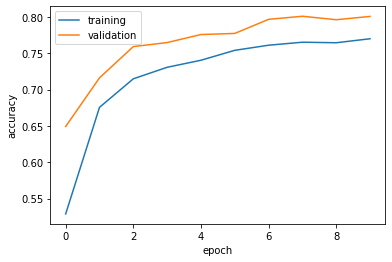

In [28]:
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label = "training")
plt.plot(history.history["val_accuracy"], label = "validation")
plt.gca().set(xlabel = "epoch", ylabel = "accuracy")
plt.legend()

In [29]:
model.evaluate(test_vec)

5967/5967 [==============================] - 10s 2ms/step - loss: 0.6566 - accuracy: 0.7994


[0.6565951108932495, 0.7993966937065125]

In [33]:
weights = model.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = vectorize_layer.get_vocabulary()                # get the vocabulary from our data prep for later

In [31]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

In [34]:
embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0],
    'x1'   : weights[:,1]
})
embedding_df

,word,x0,x1
0,,-0.013526,0.020223
1,[UNK],-0.302417,0.423590
2,pepper,0.049225,0.189311
3,salt,0.412844,-0.260715
4,oil,1.156017,-0.317406
...,...,...,...
1495,yuzu,-0.381230,0.293584
1496,wraps,-0.510117,-0.112086
1497,wing,0.386785,0.095683
1498,uncle,-0.713734,-0.588609


In [35]:
import plotly.express as px 
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1", 
                 size = list(np.ones(len(embedding_df))),
                 size_max = 2,
                 hover_name = "word")

fig.show()

In [36]:
model2 = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 20, name="embedding"),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(500, activation='relu'),
  layers.Dense(500, activation='relu'),
  layers.Dense(len(le.classes_))]
)

In [37]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          30000     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 20)          0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 20)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               10500     
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_4 (Dense)              (None, 20)               

In [38]:
model2.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam', 
              metrics=['accuracy'])

In [39]:
history2 = model2.fit(train_vec, epochs = 10, validation_data = val_vec)

Epoch 1/10
29830/29830 [==============================] - 96s 3ms/step - loss: 1.7861 - accuracy: 0.4448 - val_loss: 1.1531 - val_accuracy: 0.6427
Epoch 2/10
29830/29830 [==============================] - 95s 3ms/step - loss: 1.1347 - accuracy: 0.6605 - val_loss: 0.9045 - val_accuracy: 0.7322
Epoch 3/10
29830/29830 [==============================] - 96s 3ms/step - loss: 1.0214 - accuracy: 0.6969 - val_loss: 0.8463 - val_accuracy: 0.7508
Epoch 4/10
29830/29830 [==============================] - 95s 3ms/step - loss: 0.9388 - accuracy: 0.7194 - val_loss: 0.8149 - val_accuracy: 0.7571
Epoch 5/10
29830/29830 [==============================] - 95s 3ms/step - loss: 0.9322 - accuracy: 0.7240 - val_loss: 0.7805 - val_accuracy: 0.7669
Epoch 6/10
29830/29830 [==============================] - 95s 3ms/step - loss: 0.9258 - accuracy: 0.7298 - val_loss: 0.7993 - val_accuracy: 0.7740
Epoch 7/10
29830/29830 [==============================] - 96s 3ms/step - loss: 0.8812 - accuracy: 0.7373 - val_loss: 0

In [46]:
model3 = tf.keras.Sequential([
  layers.Embedding(max_tokens, output_dim = 20, name = "embedding"),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dense(500, activation = 'relu'),
  layers.Dropout(0.2),
  layers.Dense(500, activation = 'relu'),
  layers.Dense(500, activation = 'sigmoid'),
  layers.Dense(500, activation = 'relu'),
  layers.Dense(len(le.classes_))]
)

In [47]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          30000     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 20)          0         
_________________________________________________________________
global_average_pooling1d_6 ( (None, 20)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 500)               10500     
_________________________________________________________________
dropout_13 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_16 (Dense)             (None, 500)              

In [48]:
model3.compile(loss = losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [49]:
history3 = model3.fit(train_vec, epochs = 10, validation_data = val_vec)

Epoch 1/10
29830/29830 [==============================] - 103s 3ms/step - loss: 1.9418 - accuracy: 0.4036 - val_loss: 1.3185 - val_accuracy: 0.5899
Epoch 2/10
29830/29830 [==============================] - 104s 3ms/step - loss: 1.2768 - accuracy: 0.6062 - val_loss: 1.1299 - val_accuracy: 0.6666
Epoch 3/10
29830/29830 [==============================] - 103s 3ms/step - loss: 1.0916 - accuracy: 0.6708 - val_loss: 0.9341 - val_accuracy: 0.7073
Epoch 4/10
29830/29830 [==============================] - 103s 3ms/step - loss: 1.0322 - accuracy: 0.6967 - val_loss: 0.9035 - val_accuracy: 0.7247
Epoch 5/10
29830/29830 [==============================] - 104s 3ms/step - loss: 0.9994 - accuracy: 0.7096 - val_loss: 0.9296 - val_accuracy: 0.7337
Epoch 6/10
29830/29830 [==============================] - 103s 3ms/step - loss: 0.9785 - accuracy: 0.7148 - val_loss: 0.8808 - val_accuracy: 0.7448
Epoch 7/10
29830/29830 [==============================] - 103s 3ms/step - loss: 0.9845 - accuracy: 0.7207 - val_